In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

## Load the data

In [2]:
# Clusters
clusters = pd.read_csv('data/processed/clusters_with_stats.csv')
clusters.head()

,CLUSTER_,CORE REL EXPR_mean,CORE REL EXPR_std,SEQ_unique
0,0,0.129612,0.017409,"AATTTA,AATTCT,AATTCA,AACTTA,AAATCC,AATATG,AATA..."
1,1,0.229000,NaN,ATCCGC
2,2,0.123416,0.014622,"ACCTAC,ACCTCC,ACATCC,ACATCA,ACATAC,AAATCA,ATAT..."
3,3,0.052767,0.008386,"CGTTCC,CGTCCC,CGTCAC"
4,4,0.104843,0.013261,"CCGAAA,CCGAAT,CCGTGA,CTGCCT,CCGGAC,CAAGTC,CCGG..."


In [3]:
# uASPIre
uaspire = pd.read_csv('data/raw/uASPIre_RBS_300k_r1.csv', sep='\t', usecols=['RBS', 'IFP480', 'total_reads'])

# Get the number of records
print(f'Originally {len(uaspire)} rows')

# Remove rows with total_reads < 500
uaspire = uaspire[uaspire['total_reads'] >= 500].reset_index(drop=True)
print(f'After removing records with low number of reads {len(uaspire)} rows')

uaspire.head()

Originally 303503 rows
After removing records with low number of reads 147358 rows


,RBS,IFP480,total_reads
0,TAAGGATACTTACGCAC,0.62508,27829
1,ACTCTGGATGTAATGTG,0.15903,25038
2,ATCATCGCAAGCTGCGT,0.03045,24443
3,TGAAAGCGGGGTTCCTA,0.45974,21946
4,TTTAGAGGAACGAACAT,0.76043,18985


## Locate the core in the uASPIre dataset

### Transform the clusters dataset so we have core sequence and associated cluster and mean

In [4]:
# Create new dataframe, when one column is the core sequence (splitted SEQ_unique) and the others are the cluster and mean expression
clusters_core = (
    clusters
    .assign(SEQ_unique=clusters['SEQ_unique'].str.split(','))
    .explode('SEQ_unique')
    .reset_index(drop=True)
)

clusters_core.head()

,CLUSTER_,CORE REL EXPR_mean,CORE REL EXPR_std,SEQ_unique
0,0,0.129612,0.017409,AATTTA
1,0,0.129612,0.017409,AATTCT
2,0,0.129612,0.017409,AATTCA
3,0,0.129612,0.017409,AACTTA
4,0,0.129612,0.017409,AAATCC


### For each RBS in the uaspire dataset, find the strongest core

In [5]:
def find_best_rbs_core(rbs_sequence, core_df):
    """
    For a given RBS sequence, tries trimming 5–8 nt from the 3' end,
    extracts the preceding 6 nt each time, and looks them up in core_df.
    Returns the (core, cluster, expression) with the highest REL_EXPR_mean.
    """
    candidates = []
    for trim in range(5, 9):              # trim = 5,6,7,8
        if len(rbs_sequence) >= trim + 6:
            core = rbs_sequence[-trim-6:-trim]
            # look up matching cores in core_df
            match = core_df[core_df['SEQ_unique'] == core]
            if not match.empty:
                # if there are multiple rows per core (should not happen); take them all
                for _, row in match.iterrows():
                    candidates.append({
                        'core': core,
                        'cluster': row['CLUSTER_'],
                        'expr': row['CORE REL EXPR_mean']
                    })
    if not candidates:
        return pd.Series({'matched_core': None, 'cluster': None})

    # pick the one with maximal expression
    best = max(candidates, key=lambda x: x['expr'])
    return pd.Series({'matched_core': best['core'], 'cluster': best['cluster'], 'best_expr': best['expr']})

# Process every row in the uaspire dataframe
uaspire[['matched_core', 'cluster', 'best_expr']] = uaspire['RBS'].apply(find_best_rbs_core, core_df=clusters_core)

uaspire.head()

,RBS,IFP480,total_reads,matched_core,cluster,best_expr
0,TAAGGATACTTACGCAC,0.62508,27829,GGATAC,33,0.208820
1,ACTCTGGATGTAATGTG,0.15903,25038,TGGATG,184,0.626600
2,ATCATCGCAAGCTGCGT,0.03045,24443,GCAAGC,23,0.173730
3,TGAAAGCGGGGTTCCTA,0.45974,21946,GCGGGG,315,0.894928
4,TTTAGAGGAACGAACAT,0.76043,18985,AGGAAC,176,0.919315


## Evaluation

### Clusters vs IFP480

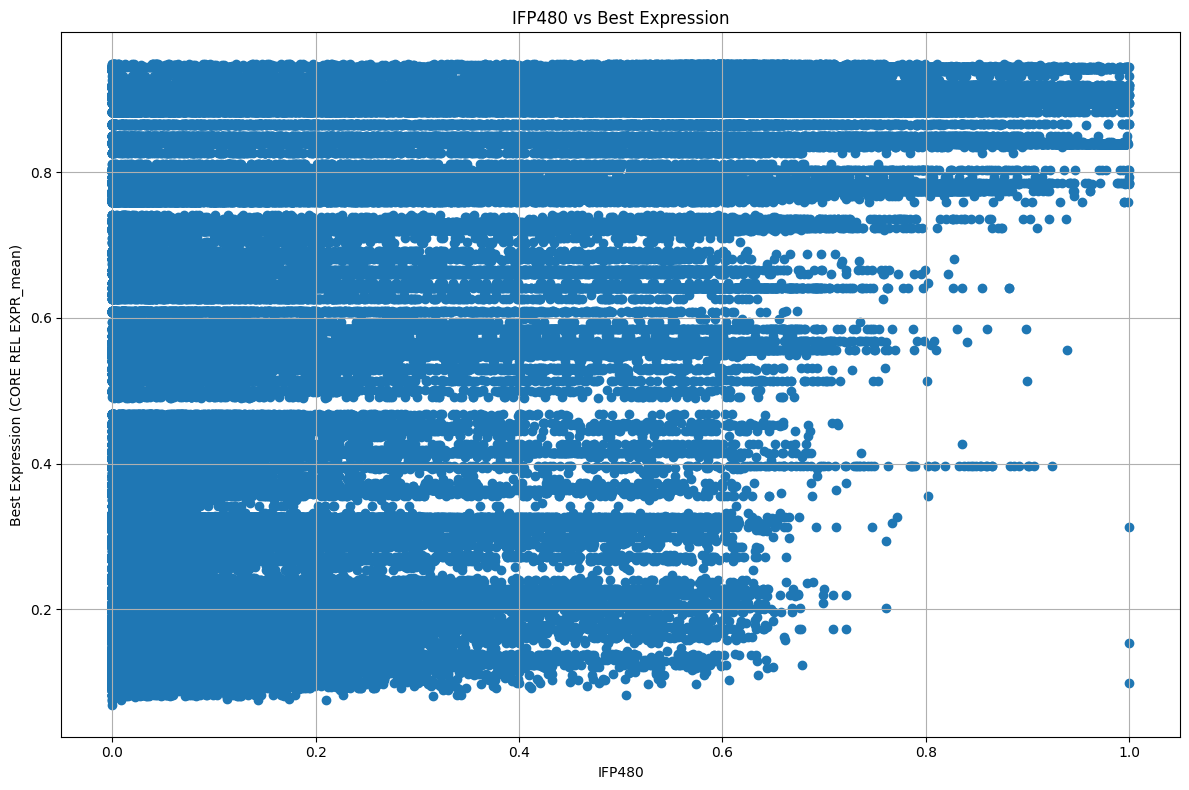

In [6]:
# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(uaspire['IFP480'], uaspire['best_expr'])
plt.xlabel('IFP480')
plt.ylabel('Best Expression (CORE REL EXPR_mean)')
plt.title('IFP480 vs Best Expression')
plt.grid(True)
plt.tight_layout()
plt.show()

## Clusters VS Aggregated IFP480

In [7]:
# Aggregate the uaspire dataframe based on clusters
aggregated_uaspire = (
    uaspire
    .groupby('cluster')
    .agg({
        'IFP480': ['mean', 'std', 'count', 'min', 'max'],
        'best_expr': ['mean', 'std', 'count'],
    })
    .reset_index()
)
aggregated_uaspire

cluster    IFP480                                   best_expr           
                 mean       std count      min      max      mean  std count
0         0  0.066069  0.092830   818  0.00000  0.63432  0.129612  0.0   818
1         1  0.043015  0.087213    85  0.00000  0.53218  0.229000  0.0    85
2         2  0.064500  0.087078  2488  0.00000  0.67808  0.123416  0.0  2488
3         4  0.071007  0.064643    15  0.00305  0.19037  0.104843  0.0    15
4         7  0.129718  0.144663  1693  0.00000  0.76645  0.318650  0.0  1693
..      ...       ...       ...   ...      ...      ...       ...  ...   ...
346     375  0.078234  0.097157   948  0.00000  0.61761  0.167036  0.0   948
347     377  0.063143  0.088257   261  0.00000  0.60609  0.103400  0.0   261
348     378  0.057305  0.073753    25  0.00000  0.31555  0.081756  0.0    25
349     379  0.058157  0.073012    42  0.00000  0.31964  0.130325  0.0    42
350     380  0.056878  0.065407    45  0.00000  0.34137  0.090636  0.0    45

[351 rows x 9 columns]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


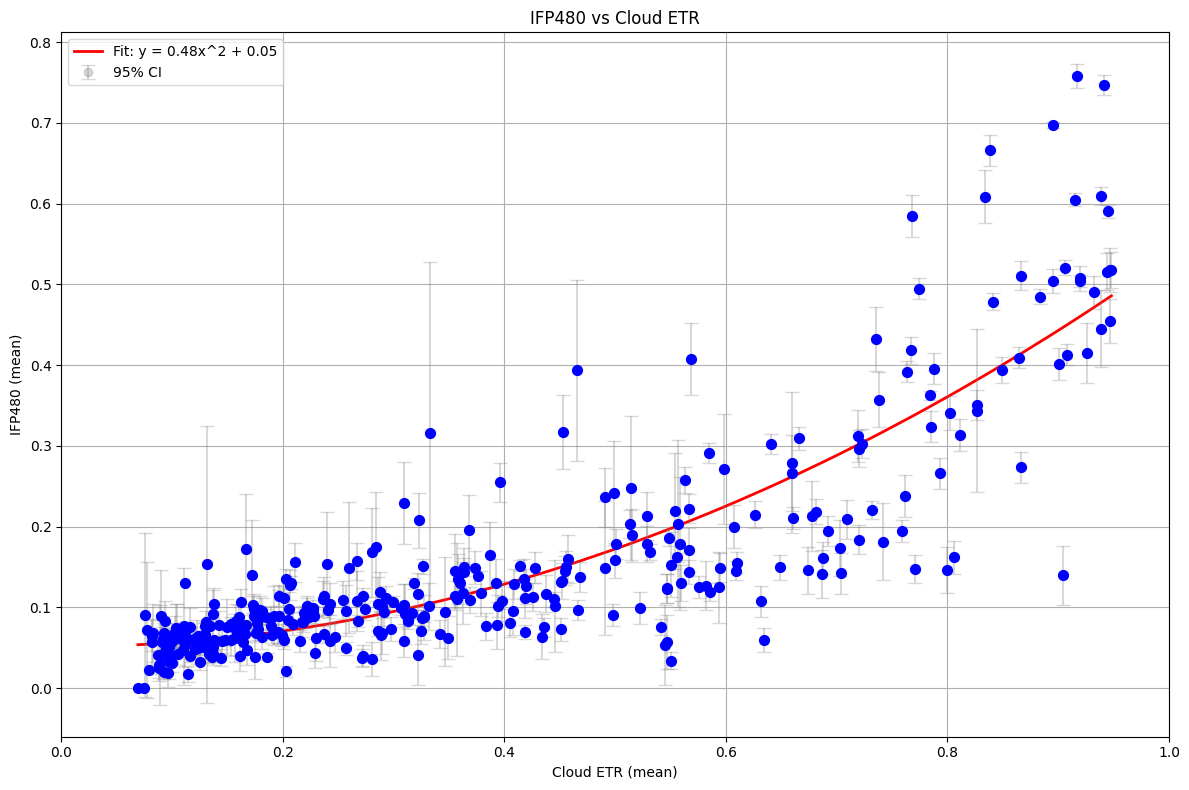

In [8]:
# Unpack into simple series for plotting & later use
x      = aggregated_uaspire['best_expr']['mean']
y      = aggregated_uaspire['IFP480']['mean']
yerr   = aggregated_uaspire['IFP480']['std']
xerr   = aggregated_uaspire['best_expr']['std']
count  = aggregated_uaspire['IFP480']['count']  # number of records in each cluster

# Fit the linear model
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Fit the quadratic model
slope, intercept, r_value, p_value, std_err = stats.linregress(x**2, y)

# Sort for a clean fill_between
idx   = np.argsort(x)
x_s   = x.iloc[idx]
y_s   = y.iloc[idx]
yerr_s = yerr.iloc[idx]

# Compute 95% CI half‐width for IFP480
ci95 = 1.96 * yerr / np.sqrt(count)
ci95_s = ci95.iloc[idx]

# Plot
plt.figure(figsize=(12, 8))

# Add a linear fit line
# plt.plot(
#     x_s,
#     slope * x_s + intercept,
#     color='red', lw=2,
#     label=f'Fit: y = {slope:.2f}x + {intercept:.2f}'
# )

# Add a quadratic fit line
plt.plot(
    x_s,
    slope * x_s**2 + intercept,
    color='red', lw=2,
    label=f'Fit: y = {slope:.2f}x^2 + {intercept:.2f}'
)

# Plot the shaded ±1SD band or
# plt.fill_between(
#     x_s,
#     y_s - yerr_s,
#     y_s + yerr_s,
#     color='grey',
#     alpha=0.3,
#     label='±1SD'
# )

# Plot the  ±95% CI as area
# plt.fill_between(
#     x_s,
#     y_s - ci95_s,
#     y_s + ci95_s,
#     color='grey',
#     alpha=0.3,
#     label='95% CI'
# )

# Plot the  ±95% CI as errorbars
plt.errorbar(
    x_s,
    y_s,
    yerr=ci95_s,
    fmt='o',
    color='grey',
    alpha=0.3,
    label='95% CI',
    capsize=5,      # length of the horizontal caps in points
    capthick=1,     # thickness of the cap lines
)

# Scatter the raw means
plt.scatter(x, y, color='blue', s=50, zorder=3)

# Add the labels & legend
plt.xlabel('Cloud ETR (mean)')
plt.ylabel('IFP480 (mean)')
plt.title('IFP480 vs Cloud ETR')
plt.grid(True)
# Limit the x axis to a reasonable range
plt.xlim(0, 1)
plt.legend(loc='upper left')
plt.tight_layout()
# Save the plot as an eps file
plt.savefig('IFP480_vs_Cloud_ETR.eps',
            format='eps',
            dpi=300,
            bbox_inches='tight')

plt.show()

In [9]:
# Check correlation coefficient
stats.pearsonr(x, y)

PearsonRResult(statistic=np.float64(0.8189299504948317), pvalue=np.float64(3.5357917654342415e-86))

## Make a visualization for our experimental data

In [10]:
# Load the experimental data
exp_data = pd.read_csv('data/raw/upv_experimental_data.csv', sep='\t')
exp_data.head()

,RBS,K_0,SIMPLE_RATE
0,TACTATTAAAGAGGAGAAATACTAGA,16.50,14.244690
1,TACTTCACACAGGAAAGTACTAGA,0.28,0.465074
2,TACTAAAGAGGAGAAATACTAGA,5.50,5.792323
3,TACTGAAAGAGGGGACAATACTAGA,0.25,0.207732
4,TACTAAAGACAGGACCTACTAGA,0.33,0.521354


In [11]:
# Process every row
exp_data[['matched_core', 'cluster', 'best_expr']] = exp_data['RBS'].apply(find_best_rbs_core, core_df=clusters_core)
exp_data

,RBS,K_0,SIMPLE_RATE,matched_core,cluster,best_expr
0,TACTATTAAAGAGGAGAAATACTAGA,16.50,14.244690,GAGAAA,150,0.866543
1,TACTTCACACAGGAAAGTACTAGA,0.28,0.465074,AGGAAA,186,0.944783
2,TACTAAAGAGGAGAAATACTAGA,5.50,5.792323,GAGAAA,150,0.866543
3,TACTGAAAGAGGGGACAATACTAGA,0.25,0.207732,GGGACA,182,0.841477
4,TACTAAAGACAGGACCTACTAGA,0.33,0.521354,AGGACC,182,0.841477


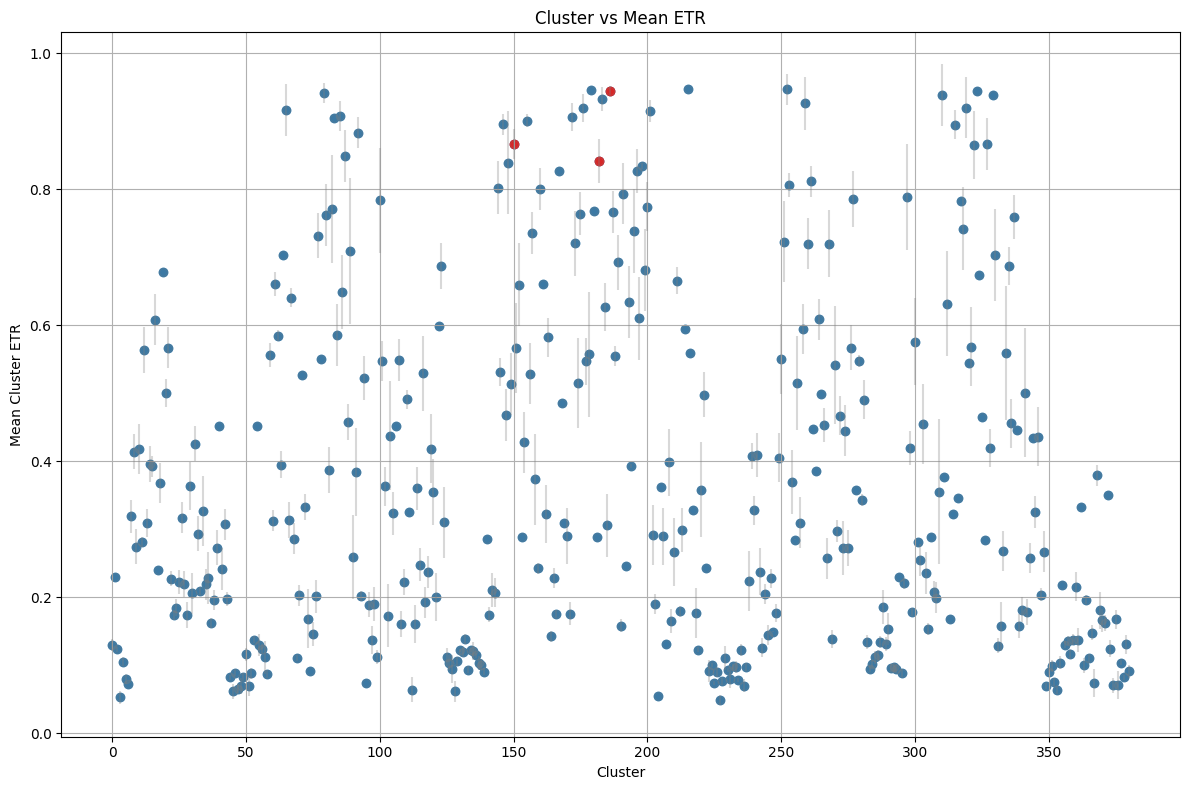

In [12]:
# Compute 95% CI half‐width from CORE REL EXPR_std
ci95 = 1.96 * clusters['CORE REL EXPR_std'] / np.sqrt(clusters['SEQ_unique'].str.count(',') + 1)

# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(clusters['CLUSTER_'], clusters['CORE REL EXPR_mean'])
plt.xlabel('Cluster')
plt.ylabel('Mean Cluster ETR')
plt.title('Cluster vs Mean ETR')

# Manually change the color for clusters 150, 182 and 186
for i in [150, 182, 186]:
    plt.scatter(clusters['CLUSTER_'][clusters['CLUSTER_'] == i], clusters['CORE REL EXPR_mean'][clusters['CLUSTER_'] == i], color='red')

# Plot the shaded ±1SD band

# Plot the  ±95% CI as errorbars
plt.errorbar(
    clusters['CLUSTER_'],
    clusters['CORE REL EXPR_mean'],
    yerr=ci95,
    fmt='o',
    color='grey',
    alpha=0.3,
    label='95% CI'
)

plt.grid(True)
plt.tight_layout()
plt.show()